In [54]:
import os

import cv2 #cv2はexifの回転を無視する
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path
#from PIL import Image, ExifTags #PILだとexifの回転情報を読み込んでしまう
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Concatenate
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cm

In [2]:
def load_image_pairs(directory, label):
    pairs = []
    subdirs = [d for d in directory.iterdir() if d.is_dir()]
    for subdir in subdirs:
    # for index, subdir in enumerate(subdirs):
    #     if index >= 10:
    #         break
        images = sorted(list(subdir.glob('*.jpeg')))
        if len(images) == 2:
            front_img = load_grayscaled_image(images[0])
            side_img = load_grayscaled_image(images[1])
            pairs.append((front_img, side_img, label))
    return pairs

def load_grayscaled_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (target_size[1], target_size[0]))
    img = np.array(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR))
    img = img / 255.0
    return np.array(img)

In [3]:
target_size = (400, 300)

In [4]:
fracture_dir = Path('./data/fracture_jpeg')
non_fracture_dir = Path('./data/non_fracture')

In [5]:
fracture_pairs = load_image_pairs(fracture_dir, 1)
non_fracture_pairs = load_image_pairs(non_fracture_dir, 0)

In [6]:
all_pairs = fracture_pairs + non_fracture_pairs
X_front = np.array([pair[0] for pair in all_pairs])
X_side = np.array([pair[1] for pair in all_pairs])
y = np.array([pair[2] for pair in all_pairs])

In [7]:
# データ分割
X_front_train, X_front_test, X_side_train, X_side_test, y_train, y_test = train_test_split(
    X_front, X_side, y, test_size=0.2, random_state=27
)

In [8]:
print(X_front_train.shape)

(223, 400, 300, 3)


In [9]:
print(X_front_train.max())

1.0


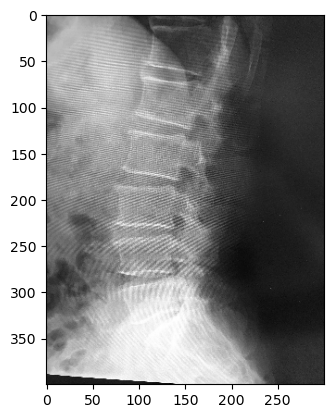

In [10]:
plt.imshow(X_side_train[20], 'gray')
plt.show()

In [14]:
vgg_front = VGG16(weights='imagenet', include_top=False, input_shape=(target_size[0],target_size[1], 3), name='front_vgg16')
for layer in vgg_front.layers:
    layer.trainable = False
    layer.name = layer.name + '_front'
x_front = Flatten()(vgg_front.output)

In [16]:
vgg_side = VGG16(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3), name='side_vgg16')
for layer in vgg_side.layers:
    layer.trainable = False
    layer.name = layer.name + '_side'
x_side = Flatten()(vgg_side.output)

In [18]:
x = Concatenate()([x_front, x_side])

for _ in range(3):
    x = Dense(32, activation='relu')(x)
else:
    output = Dense(1, activation='sigmoid')(x)

In [20]:
model = Model(inputs=[vgg_front.input, vgg_side.input], outputs=output)

In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2_front           │ (None, 400, 300, 3)       │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_3_side            │ (None, 400, 300, 3)       │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_front (Conv2D)   │ (None, 400, 300, 64)      │           1,792 │ input_layer_2_front[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_side (Conv2D)    │ (None, 400, 300, 64)      │           1,792 │ input_layer_3_side[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_front (Conv2D)   │ (None, 400, 300, 64)      │          36,928 │ block1_conv1_front[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_side (Conv2D)    │ (None, 400, 300, 64)      │          36,928 │ block1_conv1_side[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_pool_front             │ (None, 200, 150, 64)      │               0 │ block1_conv2_front[0][0]   │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_pool_side              │ (None, 200, 150, 64)      │               0 │ block1_conv2_side[0][0]    │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv1_front (Conv2D)   │ (None, 200, 150, 128)     │          73,856 │ block1_pool_front[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv1_side (Conv2D)    │ (None, 200, 150, 128)     │          73,856 │ block1_pool_side[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv2_front (Conv2D)   │ (None, 200, 150, 128)     │         147,584 │ block2_conv1_front[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv2_side (Conv2D)    │ (None, 200, 150, 128)     │         147,584 │ block2_conv1_side[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool_front             │ (None, 100, 75, 128)      │               0 │ block2_conv2_front[0][0]   │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool_side              │ (None, 100, 75, 128)      │               0 │ block2_conv2_side[0][0]    │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 32,970,497 (125.77 MB)

 Trainable params: 3,541,121 (13.51 MB)

 Non-trainable params: 29,429,376 (112.26 MB)

In [26]:
history = model.fit(
    [X_front_train, X_side_train], y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=32
)

Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 46s 8s/step - accuracy: 0.5266 - loss: 1.4192 - val_accuracy: 0.6444 - val_loss: 0.5340
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 44s 7s/step - accuracy: 0.7415 - loss: 0.4988 - val_accuracy: 0.9778 - val_loss: 0.3655
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 44s 7s/step - accuracy: 0.9368 - loss: 0.3064 - val_accuracy: 0.6444 - val_loss: 0.4660
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 44s 7s/step - accuracy: 0.9549 - loss: 0.1714 - val_accuracy: 0.9778 - val_loss: 0.1749
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 44s 7s/step - accuracy: 0.9595 - loss: 0.1444 - val_accuracy: 0.9333 - val_loss: 0.1805


In [27]:
score = model.evaluate([X_front_test, X_side_test], y_test)
print(f"Test Loss: {score[0]}")
print(f"Test Accuracy: {score[1]}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step - accuracy: 0.9539 - loss: 0.1863
Test Loss: 0.1917639523744583
Test Accuracy: 0.9464285969734192


In [28]:
print(score)

[0.1917639523744583, 0.9464285969734192]


In [29]:
y_pred = model.predict([X_front_test, X_side_test])

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 5s/step


In [36]:
y_pred_boolen = (y_pred >= 0.5)

In [42]:
 y_cm = cm(y_test, y_pred_boolen)

In [44]:
y_cm

array([[30,  2],
       [ 1, 23]], dtype=int64)

<Axes: >

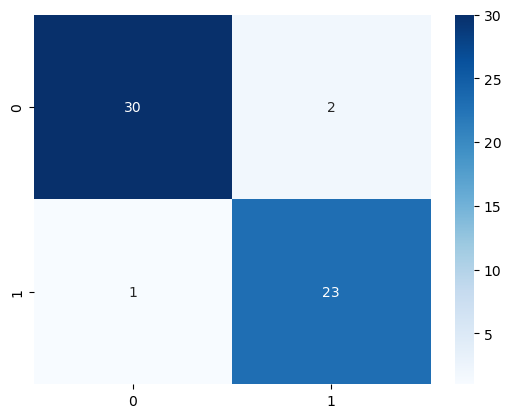

In [60]:
sns.heatmap(y_cm, annot=True, cmap='Blues')

In [62]:
23/24

0.9583333333333334

In [74]:
model.save('trained_model.keras')

In [66]:
!mkdir trained_model